In [1]:
import os
os.environ["KERAS_BACKEND"] = "jax"

import jax
import jax.numpy as jnp
import numpy as np

import jax_cfd.base as cfd

import matplotlib.pyplot as plt

plt.rcParams.update({
    "text.usetex": True
})

In [2]:
# setup problem and create grid
Lx = 2 * jnp.pi
Ly = 2 * jnp.pi
Nx = 512
Ny = 512
Re = 1000.

DATA_SCALE = 1 # legacy data at Re = 100 needs this setting = 4, 1 otherwise

grid = cfd.grids.Grid((Nx, Ny), domain=((0, Lx), (0, Ly)))

# estimate stable time step based on a "max velocity" using CFL condition
max_vel_est = 5.
dt_stable = cfd.equations.stable_time_step(max_vel_est, 0.5, 1./Re, grid) / 2.

In [3]:
data_loc = '/Users/jpage2/code/jax-cfd-data-gen/Re1000/' #Re100test/' #
file_front = 'vort_test_Re1000L2pi_' # 'vort_traj.' #
n_zeros = 4

In [4]:
def average_pool_trajectory(omega_traj, pool_width, pool_height):
  batch_size, trajectory_length, Nx, Ny, Nchannels = omega_traj.shape
  assert Nx % pool_width == 0
  assert Ny % pool_height == 0

  omega_reshaped = omega_traj.reshape(
    (batch_size, trajectory_length, Nx // pool_width, pool_width, Ny // pool_height, pool_height, Nchannels)
  )
  omega_pooled_traj = omega_reshaped.mean(axis=(3, 5))
  return omega_pooled_traj

def coarse_pool_trajectory(omega_traj, pool_width, pool_height):
  _, _, Nx, Ny, _ = omega_traj.shape
  assert Nx % pool_width == 0
  assert Ny % pool_height == 0

  coarse_x = pool_width
  coarse_y = pool_height

  omega_pooled_traj = omega_traj[:, :, ::coarse_x, :: coarse_y, :]
  return omega_pooled_traj

# pooling_fn = jax.jit(average_pool_trajectory, static_argnums=(1, 2))
pooling_fn = jax.jit(coarse_pool_trajectory, static_argnums=(1, 2))

In [27]:
filter_size = 16
n_grow = np.log2(filter_size)

import models 
model_TC = models.super_res_vel_v3(Nx // filter_size, Ny // filter_size, 32, N_grow=int(n_grow), input_channels=2)
model_FC = models.super_res_vel_v3(Nx // filter_size, Ny // filter_size, 32, N_grow=int(n_grow), input_channels=2)
model_MSE = models.super_res_vel_v3(Nx // filter_size, Ny // filter_size, 32, N_grow=int(n_grow), input_channels=2)

model_TC.load_weights('weights/paperweights1000/C' + str(int(filter_size)) + '_traj.weights.h5')
model_FC.load_weights('weights/paperweights1000/F' + str(int(filter_size)) + '_traj.weights.h5')
# model_FC.load_weights('weights/sr_best_traj.weights.h5')
model_MSE.load_weights('weights/paperweights1000/F' + str(int(filter_size)) + '_MSE.weights.h5')

In [6]:
vort_snapshots = jnp.array([np.load(data_loc + file_front + str(n).zfill(4) + '_0.npy')[np.newaxis, 0, :, :, np.newaxis] for n in range(100)]) / DATA_SCALE
vort_snapshots_coarse = coarse_pool_trajectory(vort_snapshots, filter_size, filter_size)

vort_snapshots = vort_snapshots[:, 0]
vort_snapshots_coarse = vort_snapshots_coarse[:, 0]

In [7]:
n_plot = 5

mask = np.zeros(len(vort_snapshots), dtype=bool)
mask[:n_plot] = True
np.random.shuffle(mask)

In [8]:
import interact_model as im
vort_batch = vort_snapshots[mask]
vel_batch = im.compute_vel_traj(vort_batch, Lx / Nx, Ly / Ny)
coarse_vel_batch = coarse_pool_trajectory(vel_batch[jnp.newaxis,...], filter_size, filter_size).squeeze()

Now unroll each prediction

In [28]:
from functools import partial
import time_stepping as ts
M_substep = filter_size
T_unroll = 2.5
T_da = 0.5
vel_assim = True

dt_stable = np.round(dt_stable, 3)
t_substep = M_substep * dt_stable
trajectory_fn = ts.generate_trajectory_fn(Re, T_unroll + 1e-2, dt_stable, grid, t_substep=t_substep)

def real_to_real_traj_fn(vort_phys, trajectory_fn):
  vort_rft = jnp.fft.rfftn(vort_phys, axes=(0,1))
  _, vort_traj_rft = trajectory_fn(vort_rft)
  return jnp.fft.irfftn(vort_traj_rft, axes=(1,2))

real_traj_fn = partial(real_to_real_traj_fn, trajectory_fn=trajectory_fn)

In [29]:
snap_int = 1 # within batch

vort_true = vort_batch[snap_int]
vel_true = im.compute_vel_traj(vort_true[jnp.newaxis, ...], Lx / Nx, Ly / Ny)

vel_C_pred = model_TC.predict(
  coarse_vel_batch[snap_int].reshape((1, Nx // filter_size, Ny // filter_size, 2))
  )
vel_F_pred = model_FC.predict(
  coarse_vel_batch[snap_int].reshape((1, Nx // filter_size, Ny // filter_size, 2))
  )
vel_mse = model_MSE.predict(
  coarse_vel_batch[snap_int].reshape((1, Nx // filter_size, Ny // filter_size, 2))
)

vort_C_pred = im.compute_vort_traj(vel_C_pred.reshape((1, Nx, Ny, 2)), Lx / Nx, Ly / Ny)[0]
vort_F_pred = im.compute_vort_traj(vel_F_pred.reshape((1, Nx, Ny, 2)), Lx / Nx, Ly / Ny)[0]
vort_mse = im.compute_vort_traj(vel_mse.reshape((1, Nx, Ny, 2)), Lx / Nx, Ly / Ny)[0]

true_trajectory = real_traj_fn(vort_true[...,0])
pred_C_trajectory = real_traj_fn(vort_C_pred[...,0])
pred_F_trajectory = real_traj_fn(vort_F_pred[...,0])
mse_trajectory = real_traj_fn(vort_mse[...,0])

true_trajectory = im.compute_vel_traj(true_trajectory[..., jnp.newaxis], Lx / Nx, Ly / Ny)
pred_C_trajectory = im.compute_vel_traj(pred_C_trajectory[..., jnp.newaxis], Lx / Nx, Ly / Ny)
pred_F_trajectory = im.compute_vel_traj(pred_F_trajectory[..., jnp.newaxis], Lx / Nx, Ly / Ny)
mse_trajectory = im.compute_vel_traj(mse_trajectory[..., jnp.newaxis], Lx / Nx, Ly / Ny)

# append the starting snapshot
true_trajectory = jnp.concatenate([vel_true, true_trajectory], axis=0)
pred_C_trajectory = jnp.concatenate([vel_C_pred, pred_C_trajectory], axis=0)
pred_F_trajectory = jnp.concatenate([vel_F_pred, pred_F_trajectory], axis=0)
mse_trajectory = jnp.concatenate([vel_mse, mse_trajectory], axis=0)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 801ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 699ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 696ms/step


Now build the assimilation solution too 

In [11]:
import data_assim as da
import optax 

# # hyper parameters + optimizer 
lr = 0.2
# filter_size = filter_size
opt_class = optax.adam
T_unroll = 0.5

assimilator = da.Assimilator(Re, Nx, Ny, Lx, Ly, T_unroll, filter_size, opt_class, lr, vel_assim=True)

In [12]:
n_assim_steps = 50
vel_assim = assimilator.assimilate(vort_true[..., 0], n_assim_steps)

Step:  1 Loss:  0.049088232
Step:  2 Loss:  0.018095776
Step:  3 Loss:  0.013159273
Step:  4 Loss:  0.012125063
Step:  5 Loss:  0.01085799
Step:  6 Loss:  0.009524244
Step:  7 Loss:  0.008254671
Step:  8 Loss:  0.0069598244
Step:  9 Loss:  0.005926815
Step:  10 Loss:  0.005226263
Step:  11 Loss:  0.0046988605
Step:  12 Loss:  0.004233851
Step:  13 Loss:  0.0037721316
Step:  14 Loss:  0.003445145
Step:  15 Loss:  0.0029875825
Step:  16 Loss:  0.0026444786
Step:  17 Loss:  0.0023275183
Step:  18 Loss:  0.0021132147
Step:  19 Loss:  0.0019082276
Step:  20 Loss:  0.001699127
Step:  21 Loss:  0.00155868
Step:  22 Loss:  0.0014026704
Step:  23 Loss:  0.0012653295
Step:  24 Loss:  0.0011335888
Step:  25 Loss:  0.0010212655
Step:  26 Loss:  0.00094088085
Step:  27 Loss:  0.00084641797
Step:  28 Loss:  0.0007723169
Step:  29 Loss:  0.00069992954
Step:  30 Loss:  0.0006337742
Step:  31 Loss:  0.00058441405
Step:  32 Loss:  0.0005275917
Step:  33 Loss:  0.00047777715
Step:  34 Loss:  0.0004299582

In [13]:
vort_A_pred = im.compute_vort_traj(vel_assim[jnp.newaxis, ...], Lx / Nx, Ly / Ny)[0, ..., 0]

pred_A_trajectory = real_traj_fn(vort_A_pred)
pred_A_trajectory = im.compute_vel_traj(pred_A_trajectory[..., jnp.newaxis], Lx / Nx, Ly / Ny)

Put it all together and plot

In [30]:
t_grid = np.linspace(0, 
                     len(true_trajectory) * M_substep * dt_stable, 
                     len(true_trajectory))

error_pred_C = []
error_pred_F = []
error_pred_A = []
error_mse = []
for n, _ in enumerate(t_grid):
  e_p_C = jnp.linalg.norm((true_trajectory[n] - pred_C_trajectory[n]).flatten()) / jnp.linalg.norm(vel_batch[snap_int].flatten())
  e_p_F = jnp.linalg.norm((true_trajectory[n] - pred_F_trajectory[n]).flatten()) / jnp.linalg.norm(vel_batch[snap_int].flatten())
  e_p_A = jnp.linalg.norm((true_trajectory[n] - pred_A_trajectory[n]).flatten()) / jnp.linalg.norm(vel_batch[snap_int].flatten())
  e_m = jnp.linalg.norm((true_trajectory[n] - mse_trajectory[n]).flatten()) / jnp.linalg.norm(vel_batch[snap_int].flatten())

  error_pred_C.append(e_p_C)
  error_pred_F.append(e_p_F)
  error_pred_A.append(e_p_A)
  error_mse.append(e_m)

Also label where to extract

In [31]:
T_extract = [0, 0.1, 0.25, 0.5, 1., 2.5]
N_extract = [int(t_e / (M_substep * dt_stable)) for t_e in T_extract]

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


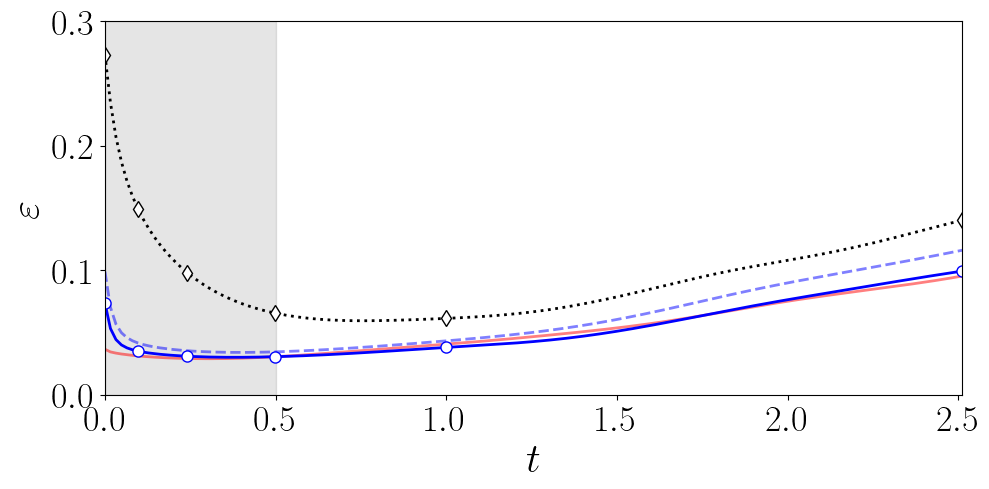

In [32]:
fig = plt.figure(figsize=(10, 5)) 
ax1 = fig.add_subplot(1, 1, 1)
ax1.tick_params(labelsize=26)

ax1.axvspan(0, T_da, color='k', alpha=0.1)

ax1.plot(t_grid, error_pred_A, c='k', linewidth=2, linestyle=':')

ax1.plot(t_grid, error_mse, c='r', linewidth=2, alpha=0.5)  
ax1.plot(t_grid, error_pred_C, c='b', linewidth=2)
ax1.plot(t_grid, error_pred_F, c='b', linewidth=2, linestyle='--', alpha=0.5)

for _, n in enumerate(N_extract):
  ax1.plot([t_grid[n]], [error_pred_C[n]], marker='o', c='b', markersize=8, markerfacecolor='w')
  ax1.plot([t_grid[n]], [error_pred_A[n]], marker='d', c='k', markersize=8, markerfacecolor='w')

ax1.set_xlabel(r'$t$', fontsize=30)
ax1.set_ylabel(r'$\varepsilon$', fontsize=30)

ax1.set_xlim(0, t_grid[-1])
# ax1.set_yscale('log')
ax1.set_ylim(0, .3) #1)

fig.tight_layout()
fig.savefig('Re' + str(int(Re)) + '_M' + str(filter_size) + '_assim_t.pdf')
fig.savefig('Re' + str(int(Re)) + '_M' + str(filter_size) + '_assim_t.eps')

Write a low pass filter function to allow for overlay of low-frequency vortical modes

In [22]:
def lowpass_rft(vort_rft_traj: jnp.ndarray, N_downsample: int) -> jnp.ndarray:
  """Downsamples an array of Fourier coefficients obtained from jnp.fft.rfftn().

  Args:
    vort_rft_traj (jnp.ndarray): Input array of Fourier coefficients.
                                     First dimension represents time.
    N_downsample (int): Downsampling factor.

  Returns:
    jnp.ndarray: Downsampled array of Fourier coefficients.
  """  
  vort_shape = vort_rft_traj.shape

  vort_filtered = np.copy(vort_rft_traj)

  # need to deal with front and back halves of rfft separately
  N_divide = 2 * N_downsample
  vort_filtered[:, :, (vort_shape[-1] // N_downsample + 1):] = 0.
  vort_filtered[:, (vort_shape[1] // N_divide):-(vort_shape[-1] // N_divide + 1), :] = 0.

  return vort_filtered

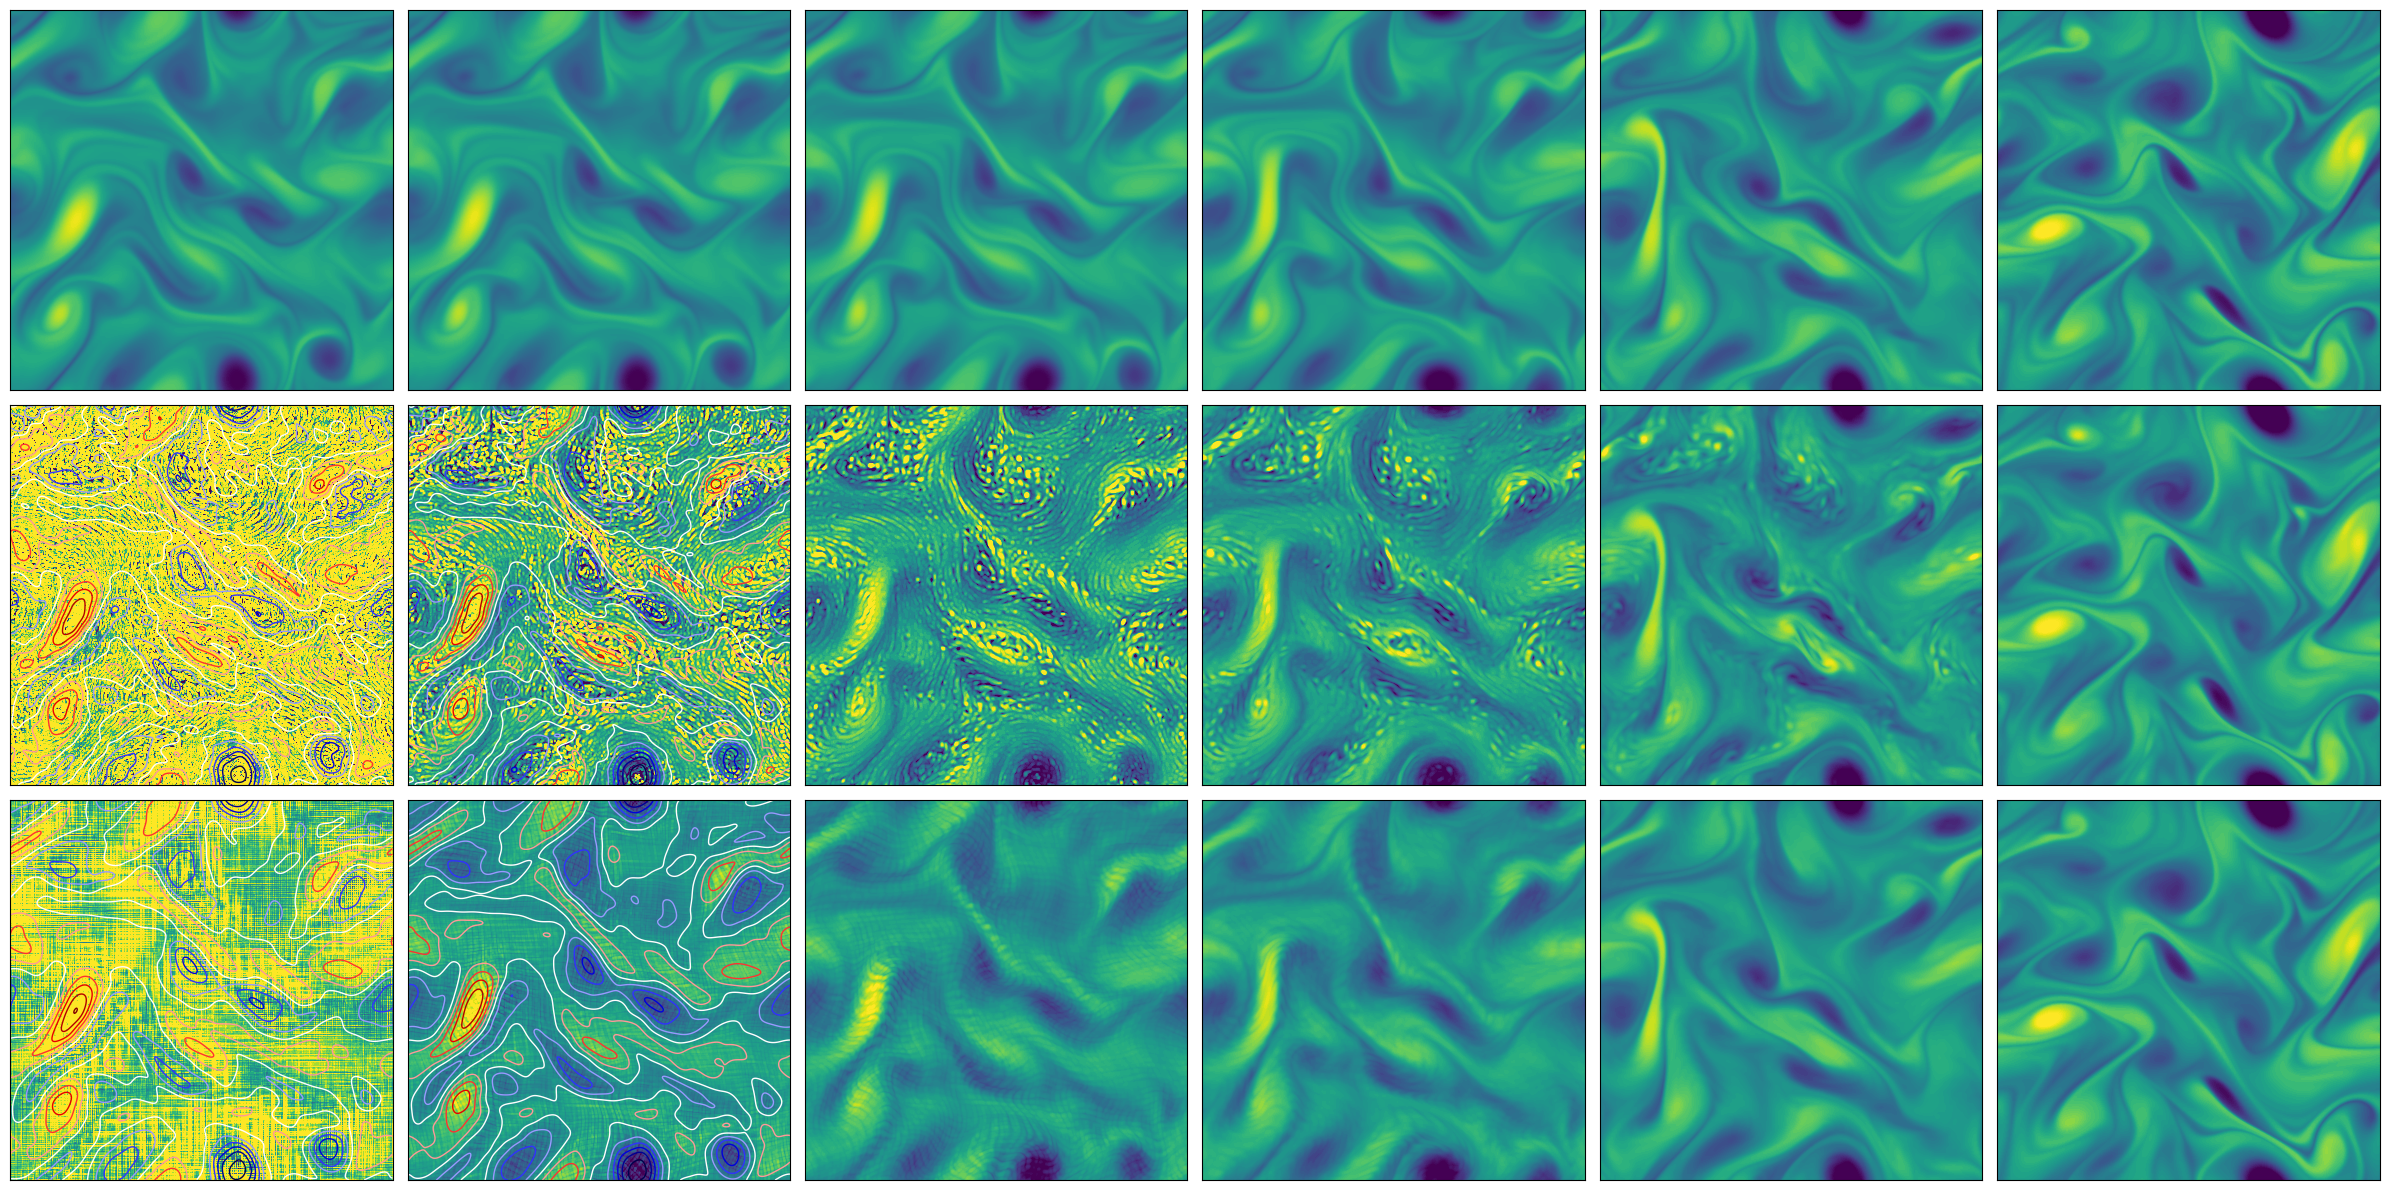

In [25]:
n_plot = len(N_extract)
vmax = 15.

fig = plt.figure(figsize=(4 * n_plot, 12))
ax_num = 1

#### following code will work only for v_comp = 2 
v_comp = 2 # if vel assim, which component to plot? if set to "2" -> plot vorticity

# compute vort (again ... ) if plotting
if v_comp > 1:
  vort_true_traj = im.compute_vort_traj(true_trajectory, Lx / Nx, Ly / Ny)[..., 0]
  vort_pred_traj = im.compute_vort_traj(pred_C_trajectory, Lx / Nx, Ly / Ny)[..., 0]
  vort_ass_traj = im.compute_vort_traj(pred_A_trajectory, Lx / Nx, Ly / Ny)[..., 0]

  vort_pred_downsampled = jnp.fft.irfftn(
    lowpass_rft(jnp.fft.rfftn(np.array(vort_pred_traj), axes=(1,2)), filter_size),
    axes=(1,2)
  )

  vort_ass_downsampled = jnp.fft.irfftn(
    lowpass_rft(jnp.fft.rfftn(np.array(vort_ass_traj), axes=(1,2)), filter_size),
    axes=(1,2)
  )

# for vort, vort_coarse in zip(vort_snapshots[:n_plot], vort_snapshots_coarse[:n_plot]):
for m, n in enumerate(N_extract):
  v_true = vort_true_traj[n]
  v_pred = vort_pred_traj[n]
  v_ass = vort_ass_traj[n]

  v_pred_ds = vort_pred_downsampled[n]
  v_ass_ds = vort_ass_downsampled[n]

  ax = fig.add_subplot(3, n_plot, ax_num)
  ax.contourf(v_true.T, 101, vmax=vmax, vmin=-vmax)
  ax.set_xticks([])
  ax.set_yticks([])

  ax = fig.add_subplot(3, n_plot, ax_num + n_plot)
  ax.contourf(v_ass.T, 101, vmax=vmax, vmin=-vmax)
  if m < 2:
    ax.contour(v_ass_ds.T, 11, cmap='seismic', linewidths=1, levels=np.linspace(-vmax, vmax, 11)) #vmax=vmax, vmin=-vmax)
  ax.set_xticks([])
  ax.set_yticks([])

  ax = fig.add_subplot(3, n_plot, ax_num + 2 * n_plot)
  ax.contourf(v_pred.T, 101, vmax=vmax, vmin=-vmax)
  # plot interpolated low-pass filtered image -- actually shouldn't need to interpolate
  if m < 2:
    ax.contour(v_pred_ds.T, 11, cmap='seismic', linewidths=1, levels=np.linspace(-vmax, vmax, 11)) #vmax=vmax, vmin=-vmax)
  ax.set_xticks([])
  ax.set_yticks([])

  ax_num += 1
fig.tight_layout()

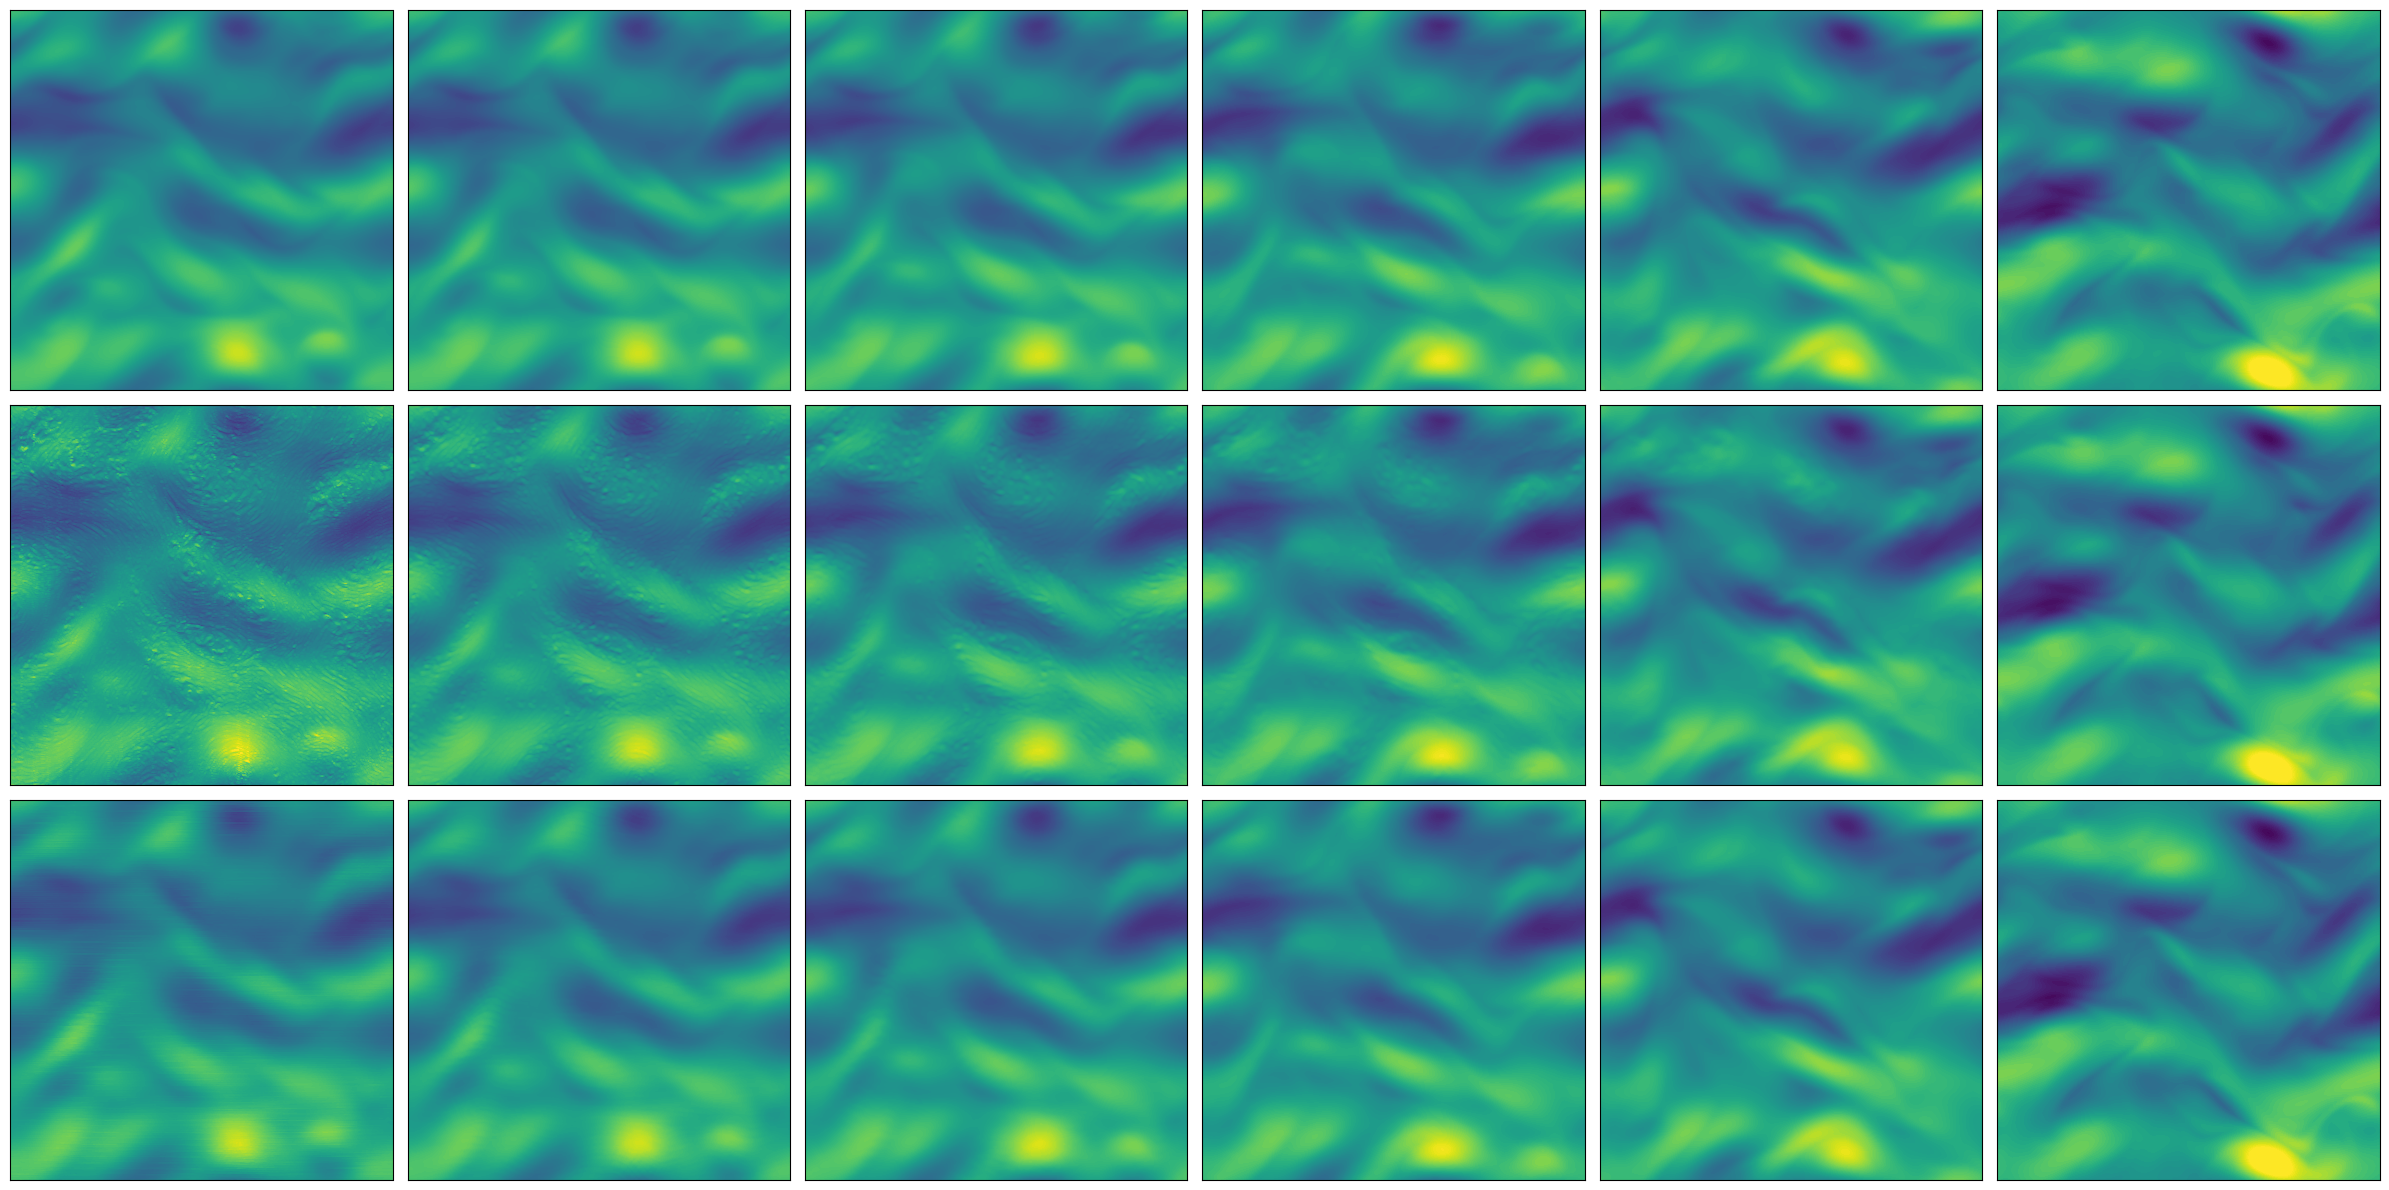

In [24]:
n_plot = len(N_extract)
vmax = 3.

fig = plt.figure(figsize=(4 * n_plot, 12))
ax_num = 1

v_comp = 0 # 0 or 1 

# for vort, vort_coarse in zip(vort_snapshots[:n_plot], vort_snapshots_coarse[:n_plot]):
for m, n in enumerate(N_extract):
  v_true = true_trajectory[n, ..., v_comp]
  v_pred = pred_C_trajectory[n, ..., v_comp]
  v_ass = pred_A_trajectory[n, ..., v_comp]

  ax = fig.add_subplot(3, n_plot, ax_num)
  ax.contourf(v_true.T, 101, vmax=vmax, vmin=-vmax)
  ax.set_xticks([])
  ax.set_yticks([])

  ax = fig.add_subplot(3, n_plot, ax_num + n_plot)
  ax.contourf(v_ass.T, 101, vmax=vmax, vmin=-vmax)
  ax.set_xticks([])
  ax.set_yticks([])

  ax = fig.add_subplot(3, n_plot, ax_num + 2 * n_plot)
  ax.contourf(v_pred.T, 101, vmax=vmax, vmin=-vmax)
  ax.set_xticks([])
  ax.set_yticks([])

  ax_num += 1
fig.tight_layout()